In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import scipy.stats as spicystats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# data = arff.loadarff('../data/dataset.arff')
# df = pd.DataFrame(data[0])

,annual_inc,short_emp,emp_length_num,home_ownership,dti,purpose,term,last_delinq_none,revol_util,total_rec_late_fee,od_ratio,bad_loan
0,100000.0,1,1,RENT,26.27,credit_card,36 months,1,43.2,0.0,0.160624,0
1,83000.0,0,4,OWN,5.39,credit_card,36 months,0,21.5,0.0,0.810777,0
2,78000.0,0,11,MORTGAGE,18.45,debt_consolidation,60 months,1,46.3,0.0,0.035147,1
3,37536.0,0,6,MORTGAGE,12.28,medical,60 months,0,10.7,0.0,0.534887,1
4,65000.0,0,11,MORTGAGE,11.26,debt_consolidation,36 months,0,15.2,0.0,0.166500,0
...,...,...,...,...,...,...,...,...,...,...,...,...
19995,27000.0,0,9,RENT,18.36,debt_consolidation,36 months,1,46.5,0.0,0.821782,1
19996,45000.0,0,2,MORTGAGE,23.22,major_purchase,36 months,0,46.2,0.0,0.652200,0
19997,104000.0,0,5,MORTGAGE,13.27,debt_consolidation,36 months,1,78.5,0.0,0.482555,0
19998,38400.0,0,2,MORTGAGE,12.84,debt_consolidation,36 months,0,47.4,0.0,0.822980,0


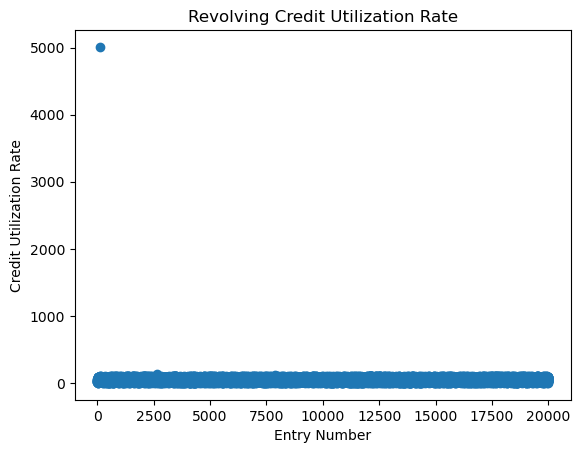

In [2]:
df = pd.read_csv('../data/lending_club_loan_dataset.csv')

# 'last_major_derog_none' feature has 97.13% null values, this column is dropped below
df.drop('last_major_derog_none', axis=1, inplace=True)

# grade feature is dropped because it is the evaluation of risk on the given loan,
# presumably using the same data given in the other features to predict loan default

# ID feature is also dropped, it is just an identifier and not connected to other data
df.drop('grade', axis=1, inplace=True)
df.drop('id', axis=1, inplace=True)

# all other rows with null values are dropped
df.dropna(inplace=True)
# dataset now has 18371 entries instead of 20000

# 'term' feature had varying punctuation and a added space in the string, replace
# method was used to standardize the entries
df.replace({' 36 months': '36 months', ' 36 Months': '36 months', ' 60 months': '60 months'}, inplace=True)

# 'revol_util' column contained one large outlier that is likely a mis-entry
# column represents revolving credit utilization rate as a percentage
# value of 5010.0 is likely a mis-entry as the second highest value is 128.1
fig, ax = plt.subplots()
ax.scatter(df.index, df['revol_util'])
ax.set_title('Revolving Credit Utilization Rate')
ax.set_ylabel('Credit Utilization Rate')
ax.set_xlabel('Entry Number')
df['revol_util'].sort_values(ascending=False).head(5)
df = df[df['revol_util'] <= 200]
# dataset now has 18370 entries


# df.describe(include=[object])
# df['bad_loan'][df['home_ownership'] == 'RENT']
# df['bad_loan'][df['last_delinq_none'] == 0]
df

In [3]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
annual_inc,18370.0,73421.19,45614.20,8412.0,47000.00,65000.00,88000.00,1000000.00
short_emp,18370.0,0.11,0.32,0.0,0.00,0.00,0.00,1.00
emp_length_num,18370.0,6.83,3.77,0.0,3.00,7.00,11.00,11.00
dti,18370.0,16.59,7.58,0.0,10.85,16.22,22.06,34.99
last_delinq_none,18370.0,0.55,0.50,0.0,0.00,1.00,1.00,1.00
revol_util,18370.0,55.73,23.42,0.0,38.72,57.10,74.00,128.10
total_rec_late_fee,18370.0,0.29,3.14,0.0,0.00,0.00,0.00,96.47
od_ratio,18370.0,0.50,0.29,0.0,0.26,0.51,0.75,1.00
bad_loan,18370.0,0.20,0.40,0.0,0.00,0.00,0.00,1.00


In [4]:
df.columns

Index(['annual_inc', 'short_emp', 'emp_length_num', 'home_ownership', 'dti',
       'purpose', 'term', 'last_delinq_none', 'revol_util',
       'total_rec_late_fee', 'od_ratio', 'bad_loan'],
      dtype='object')

In [5]:
# creation of EDA dfs

df_categorical_eda = df[['home_ownership', 'purpose', 'term']]
df_numerical_eda = df[['emp_length_num', 'dti', 'revol_util', 'od_ratio']]
df_binary_eda = df[['short_emp', 'last_delinq_none']]
df_annual_income_eda = df['annual_inc']

([<matplotlib.patches.Wedge at 0x7ff21a495bb0>,
 [Text(-0.6479327618778429, -0.8889224578585867, 'Good Loan'),
  Text(0.6479328034913053, 0.8889224275266643, 'Bad Loan')],
 [Text(-0.353417870115187, -0.48486679519559267, '79.95%  (14687)'),
  Text(0.35341789281343927, 0.4848667786509077, '20.05%  (3683)')])

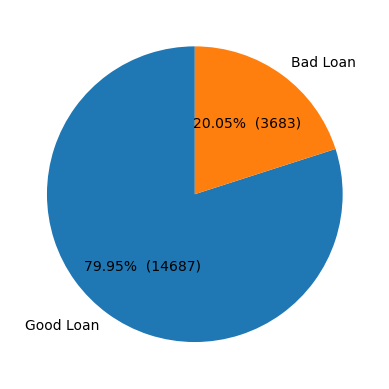

In [6]:
## grouping data together by loan outcome, finding total amount of good and bad loans

loans_grouped = df.groupby('bad_loan').count()

def make_autopct(values):
    def my_autopct(pct):
        total = np.sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v})'.format(p=pct,v=val)
    return my_autopct

make_autopct(loans_grouped.T.iloc[0])

fig, ax = plt.subplots()
ax.pie(loans_grouped['annual_inc'], labels=['Good Loan', 'Bad Loan'], \
        startangle=90, autopct=make_autopct(loans_grouped.T.iloc[0]), pctdistance=0.6)

# default rate of 0.2

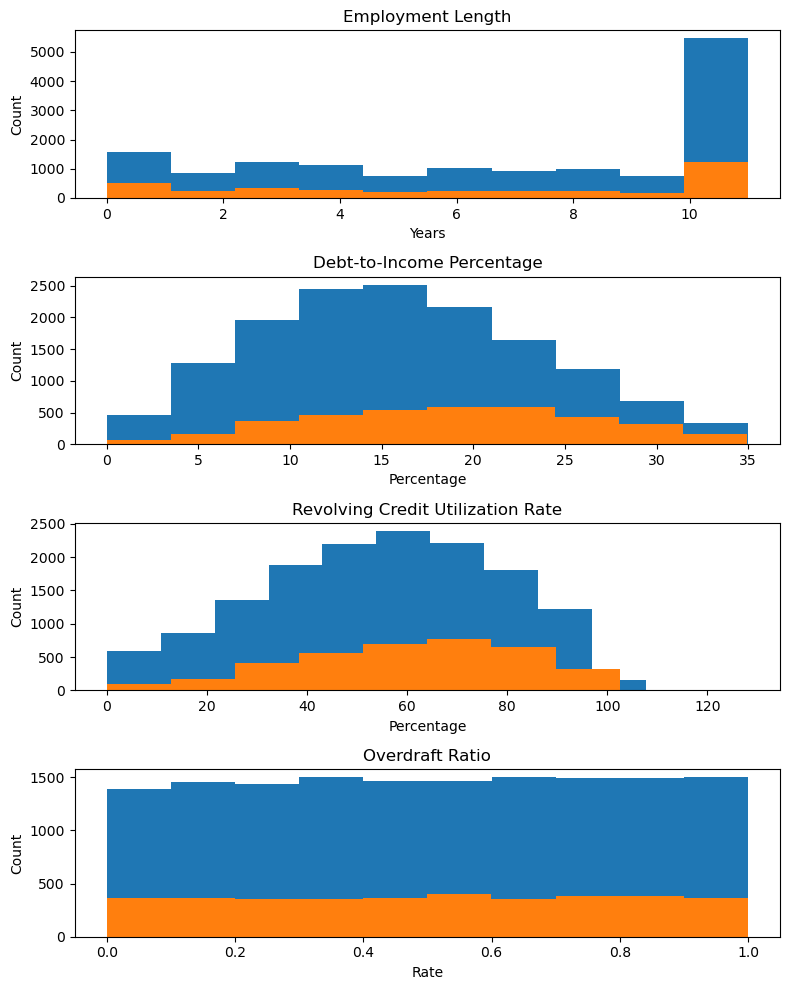

In [7]:
# numerical features distribution

fig, ax = plt.subplots(4, 1, figsize=(8, 10))
for idx, val in enumerate(df_numerical_eda.columns):
    ax[idx].hist(df[val][df['bad_loan'] == 0])
    ax[idx].hist(df[val][df['bad_loan'] == 1])
    ax[idx].set_title(val)
ax[0].set_title('Employment Length')
ax[0].set_xlabel('Years')
ax[0].set_ylabel('Count')
ax[1].set_title('Debt-to-Income Percentage')
ax[1].set_xlabel('Percentage')
ax[1].set_ylabel('Count')
ax[2].set_title('Revolving Credit Utilization Rate')
ax[2].set_xlabel('Percentage')
ax[2].set_ylabel('Count')
ax[3].set_title('Overdraft Ratio')
ax[3].set_xlabel('Rate')
ax[3].set_ylabel('Count')

fig.tight_layout()

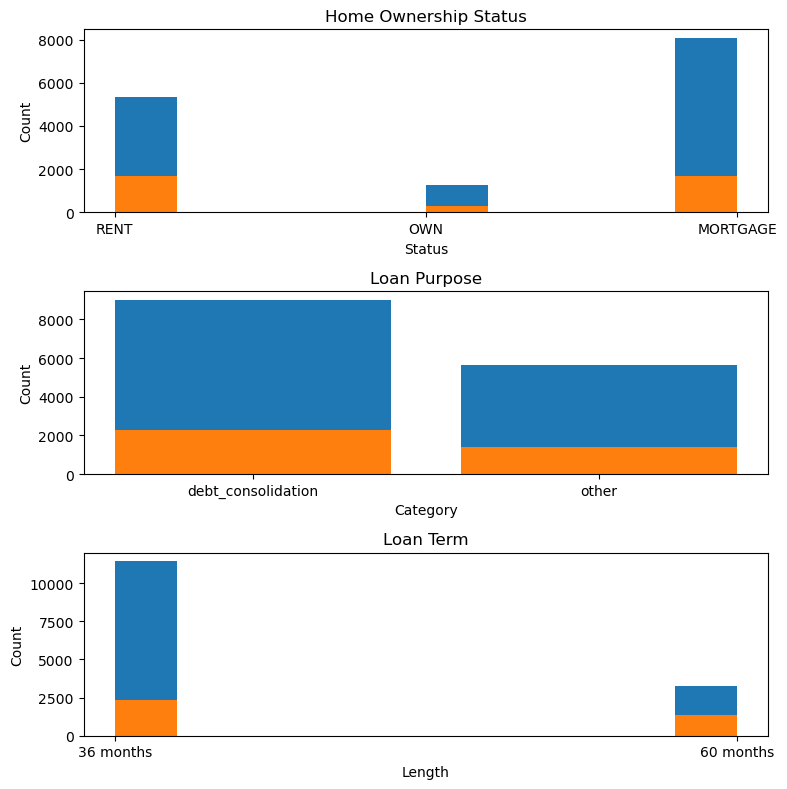

In [8]:
# categorical features distribution

boolean_mask1 = (df['purpose'] == 'debt_consolidation') & (df['bad_loan'] == 0)
boolean_mask2 = (df['purpose'] != 'debt_consolidation') & (df['bad_loan'] == 0)
boolean_mask3 = (df['purpose'] == 'debt_consolidation') & (df['bad_loan'] == 1)
boolean_mask4 = (df['purpose'] != 'debt_consolidation') & (df['bad_loan'] == 1)

fig, ax = plt.subplots(3,1, figsize=(8,8))
for idx, val in enumerate(df_categorical_eda.columns):
    if val == 'purpose':
        ax[idx].bar(0, df[val][boolean_mask1].count(), color=['tab:blue'])
        ax[idx].bar(1, df[val][boolean_mask2].count(), color=['tab:blue'])
        ax[idx].bar(0, df[val][boolean_mask3].count(), color=['tab:orange'])
        ax[idx].bar(1, df[val][boolean_mask4].count(), color=['tab:orange'])
        ax[idx].set_xticks([0,1], ['debt_consolidation', 'other'])
    else:
        pass
        ax[idx].hist(df[val][df['bad_loan'] == 0])
        ax[idx].hist(df[val][df['bad_loan'] == 1])
    ax[idx].set_title(val)
ax[0].set_title('Home Ownership Status')
ax[0].set_xlabel('Status')
ax[0].set_ylabel('Count')
ax[1].set_title('Loan Purpose')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Count')
ax[2].set_title('Loan Term')
ax[2].set_xlabel('Length')
ax[2].set_ylabel('Count')

fig.tight_layout()

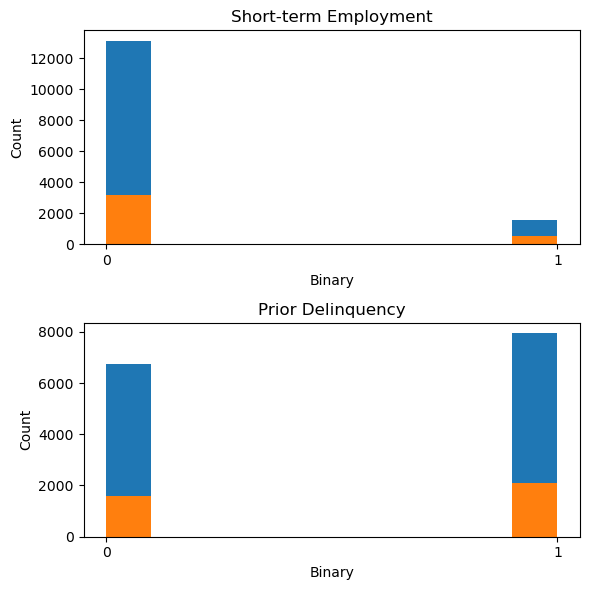

In [9]:
# binary features distribution

fig, ax = plt.subplots(2, 1, figsize=(6, 6))
for idx, val in enumerate(df_binary_eda.columns):
    ax[idx].hist(df[val][df['bad_loan'] == 0])
    ax[idx].hist(df[val][df['bad_loan'] == 1])
    ax[idx].set_title(val)
ax[0].set_title('Short-term Employment')
ax[0].set_xlabel('Binary')
ax[0].set_ylabel('Count')
ax[0].set_xticks([0,1])
ax[1].set_title('Prior Delinquency')
ax[1].set_xlabel('Binary')
ax[1].set_ylabel('Count')
ax[1].set_xticks([0,1])
fig.tight_layout()

/var/folders/w9/0y2smhf95qd_4dp0mg3n1vbh0000gn/T/ipykernel_2474/1792383422.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['-$200,000', '$0', '$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000'])


[Text(0, -200000.0, '-$200,000'),
 Text(0, 0.0, '$0'),
 Text(0, 200000.0, '$200,000'),
 Text(0, 400000.0, '$400,000'),
 Text(0, 600000.0, '$600,000'),
 Text(0, 800000.0, '$800,000'),
 Text(0, 1000000.0, '$1,000,000'),
 Text(0, 1200000.0, '')]

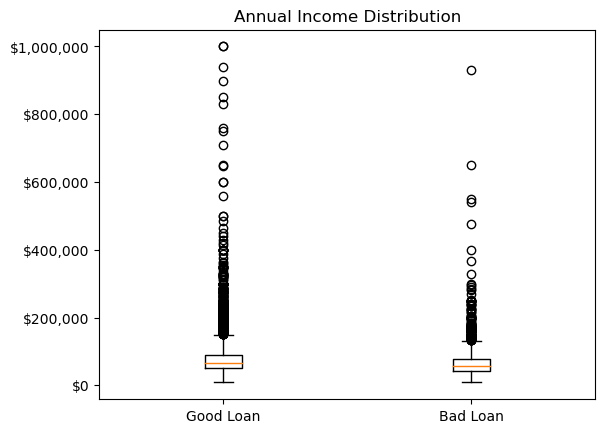

In [10]:
# annual income distribution
fig, ax = plt.subplots()
ax.boxplot([df['annual_inc'][df['bad_loan'] == 0], df['annual_inc'][df['bad_loan'] == 1]])
ax.set_xticklabels(['Good Loan', 'Bad Loan'])
ax.set_title('Annual Income Distribution')
ax.set_yticklabels(['-$200,000', '$0', '$200,000', '$400,000', '$600,000', '$800,000', '$1,000,000'])

In [11]:
## adding dummy variables for categorical features
df_dummies = pd.get_dummies(df, columns=['home_ownership', 'purpose', 'term'])

In [12]:
## Prediction model for good/bad loan
## logistic regression

X = df_dummies.drop('bad_loan', axis=1)
y = df_dummies['bad_loan']
randomseed=8

X_data, X_holdout, y_data, y_holdout = train_test_split(X, y, test_size=0.2, random_state=randomseed, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.25, random_state=randomseed, stratify=y_data)

In [13]:
log_model = LogisticRegression(random_state=randomseed).fit(X_train, y_train)
log_model.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])